# Анализ отзывов на банки

В данных представлены отзывы на банки с сайта [banki.ru](https://www.banki.ru/)
- body - сам отзыв
- title - название отзыва
- rating - оценка по отзыву, варьируется от 1 до 5
- bank_name - название банка
- date - дата публикации отзыва

Необходимо EDA (Exploratory Data Analysis) по этим данным и сделать несколько выводов (приветствуются визуализации):
ё- назвать топ-15 банков по числу отзывов
- какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?
- сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов
- нет ли в данных в целом каких-то странностей на ваш взгляд?
- дополнительный EDA на ваше усмотрение, возможные интересные наблюдения

Необходимо выбрать метрику и построить бинарный классификатор отзывов, добившись при этом лучшей метрики на валидационной выборке (отзывы >=3 считать положительными, <3 - отрицательными)

Будет плюсом визуализация результатов работы модели (ответ на вопрос: почему построенная модель считает этот отзыв положительным или отрицательным?)

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [123]:
data = pd.read_csv('parsed_reviews3.csv', sep = ',', encoding='utf-8')
data['rating'] = data['rating'].astype(int)
data['date'] = pd.to_datetime(data['date'])
print(f'В исходном датафрейма {data.shape[0]} строк и {data.shape[1]} столбцов')
data.head(5)

В исходном датафрейма 92735 строк и 5 столбцов


,body,title,rating,bank_name,date
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11
1,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11
3,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36


### Часть 1 - EDA

Для начала поищем странности в исходных данных

In [124]:
# нет ни одного NaN - это хорошо
data.isnull().any()

body         False
title        False
rating       False
bank_name    False
date         False
dtype: bool

In [125]:
# с типами данных тоже все в порядке
data.dtypes

body                 object
title                object
rating                int32
bank_name            object
date         datetime64[ns]
dtype: object

In [126]:
# но есть дубликаты
data.duplicated().any()

True

In [127]:
# посмотрим на них
print(f'В датафрейме {data[data.duplicated()].shape[0]} дубликатов')
data[data.duplicated()].head(5)

В датафрейме 62 дубликатов


,body,title,rating,bank_name,date
899,&lt;p&gt;Обратился 3 декабря в районе 19 часов...,открытие счёта и получение банковской карты,5,Хоум Кредит Банк,2022-12-30 16:16:13
997,&lt;p&gt;С самого открытия являемся клиентами ...,"Сняли деньги за перевод физ.лицу, а услугу не ...",1,Норвик Банк,2022-12-30 14:06:33
1611,&lt;p&gt;22.12.2022 в чате своего ЛК мобильног...,Отсутствие информации о порядке конвертации ва...,2,Росбанк,2022-12-29 15:03:06
2502,"&lt;p&gt;Оформлял рассрочку на телефон, в мага...",Лучший кредитный банк,5,Хоум Кредит Банк,2022-12-28 13:44:16
2504,&lt;p&gt;28 декабря я посетил банк МКБ по адре...,Отличное обслуживание,5,Московский Кредитный Банк,2022-12-28 13:42:41


In [128]:
# удалим дубликаты
data = data.drop_duplicates()

На первый взгляд в датасете нет каких-то явно выраженных аномалий, так что можно выполнить **первые три задачи**:
- назвать топ-15 банков по числу отзывов
- какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?
- сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов 

In [129]:
# топ-15 банков по числу отзывов
banks_reviews_and_rating = data.groupby(['bank_name']).agg({'body':'count', 'rating': 'mean'}).reset_index()
banks_reviews_and_rating.columns = ['bank_name', 'count', 'rating']
banks_reviews_and_rating['rating'] = banks_reviews_and_rating['rating'].round(2)
banks_reviews_and_rating.sort_values(by='count', ascending=False, inplace=True)
top15_banks_by_count = banks_reviews_and_rating.head(15).reset_index(drop=True)
top15_banks_by_count

,bank_name,count,rating
0,Тинькофф Банк,44852,4.78
1,Хоум Кредит Банк,9301,4.51
2,Совкомбанк,6100,4.26
3,ВТБ,3814,1.95
4,СберБанк,3487,2.30
5,Альфа-Банк,3368,1.71
6,Россельхозбанк,3062,4.46
7,Банк Открытие,1894,3.54
8,МТС Банк,1542,2.90
9,Модульбанк,1452,4.78


In [130]:
# банк с самым высоким рейтингом из числа топ-15 банков по отзывам
top1_bank_by_rating = top15_banks_by_count.sort_values(by='rating', ascending=False).head(1)
top1_bank_by_rating

,bank_name,count,rating
0,Тинькофф Банк,44852,4.78


Больше всего отзывов было оставлено к следующим банкам:

*Тинькофф Банк, Хоум Кредит Банк, Совкомбанк, ВТБ, СберБанк, Альфа-Банк, Россельхозбанк, Банк Открытие, МТС Банк, Модульбанк, Газпромбанк, Московский Кредитный Банк, Азиатско-Тихоокеанский Банк, Уральский Банк Реконструкции и Развития, Русский Стандарт*

Из них, *Тинькофф Банк* имеет самый высокий средний рейтинг - *4.78*

Для ответа на третий вопрос создадим колонку *year_month* (вместе с колонками *day*, *hour* и т.д. - они понадобятся позже) и сгруппируем датасет

In [132]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['hour'] = data['date'].dt.hour
data['minute'] = data['date'].dt.minute
data['second'] = data['date'].dt.second

In [133]:
# построим график изменения среднего рейтинга по месяцам у топ-5 банков по числу отзывов
data['year_month'] = data['year'].astype(str) + '-' + data['month'].astype(str)
data_to_graph = data[['bank_name','year_month','rating']]
data_to_graph = data_to_graph[data_to_graph['bank_name'].isin(top15_banks_by_count.head(5)['bank_name'])].groupby(['bank_name', 'year_month']).agg({'rating': 'mean'}).reset_index()
data_to_graph['rating'] = data_to_graph['rating'].round(2)
order = ['2022-9', '2022-10', '2022-11', '2022-12', '2023-1']
data_to_graph['year_month'] = pd.Categorical(data_to_graph['year_month'], categories=order, ordered=True)
data_to_graph = data_to_graph.sort_values(by=['bank_name', 'year_month']).reset_index(drop=True)
data_to_graph.head(10)

,bank_name,year_month,rating
0,ВТБ,2022-9,2.07
1,ВТБ,2022-10,1.91
2,ВТБ,2022-11,1.99
3,ВТБ,2022-12,1.90
4,ВТБ,2023-1,1.15
5,СберБанк,2022-9,1.92
6,СберБанк,2022-10,2.78
7,СберБанк,2022-11,2.56
8,СберБанк,2022-12,1.87
9,СберБанк,2023-1,1.40


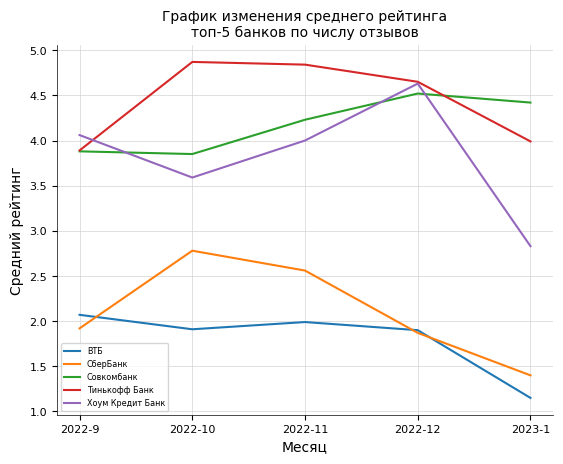

In [134]:
# data_to_graph['month'] = data_to_graph['month'].astype(str)
banks = data_to_graph['bank_name'].unique()

# plt.figure(figsize=(8, 5))
for b in banks:
    bank_data = data_to_graph[data_to_graph['bank_name'] == b]
    plt.plot(bank_data['year_month'], bank_data['rating'], label=b)
plt.title('График изменения среднего рейтинга\nтоп-5 банков по числу отзывов', fontsize=10)
plt.xlabel('Месяц')
plt.ylabel('Средний рейтинг')
plt.box(True)
plt.legend(fontsize='xx-small', loc='lower left')
plt.grid(True, linestyle='-', linewidth=0.5, color='lightgrey')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
plt.show()


##### Выводs

помогите

запомним, сбера с октября и хоум кредит банка с декабря рейтинг сильно упал
а растет рейтинг только у совкомбанка

---

Теперь проанализируем временные данные

In [135]:
hour_data = data.groupby(['hour']).count().reset_index().iloc[:, :2]
hour_data.head(5)

,hour,body
0,0,2123
1,1,1385
2,2,945
3,3,630
4,4,677


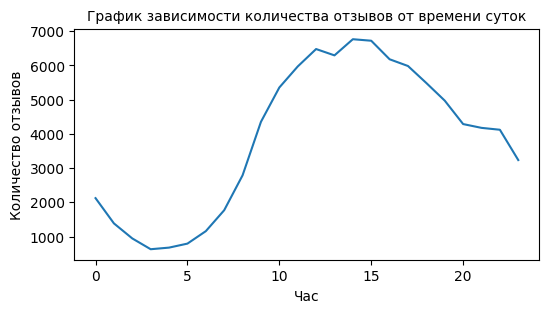

In [136]:
plt.figure(figsize=(6, 3))
plt.plot(hour_data['hour'], hour_data['body'])
plt.title('График зависимости количества отзывов от времени суток', fontsize=10)
plt.xlabel('Час')
plt.ylabel('Количество отзывов')
plt.show()

In [137]:
hour_rating_data = data.groupby(['hour']).agg({'rating': 'mean'}).reset_index()

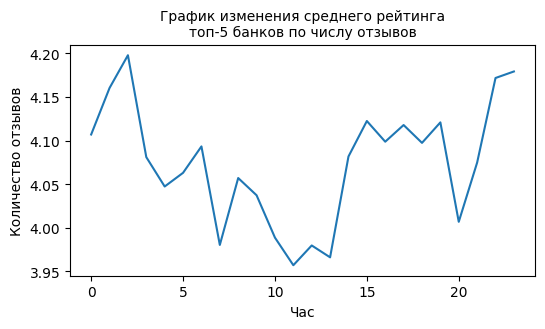

In [138]:
plt.figure(figsize=(6, 3))
plt.plot(hour_rating_data['hour'], hour_rating_data['rating'])
plt.title('График изменения среднего рейтинга\nтоп-5 банков по числу отзывов', fontsize=10)
plt.xlabel('Час')
plt.ylabel('Количество отзывов')
plt.show()

In [162]:
# посмотрим, в какое время пишут негативные отзывы, а в какое - позитивные
pos_and_neg_hour = data[data['rating'].isin([1, 5])].groupby(['hour', 'rating']).size().reset_index(name='count')
pos_and_neg_hour.head(6)

,hour,rating,count
0,0,1,392
1,0,5,1562
2,1,1,251
3,1,5,1045
4,2,1,160
5,2,5,722


In [190]:
count_rating_1 = pos_and_neg_hour[pos_and_neg_hour['rating'] == 1]['count'].sum()
count_rating_5 = pos_and_neg_hour[pos_and_neg_hour['rating'] == 5]['count'].sum()
pos_and_neg_hour['percentage'] = pos_and_neg_hour.apply(lambda row: row[2]/count_rating_1 * 100 if row[1] == 1 else row[2]/count_rating_5 * 100, axis=1).round(2)
pos_and_neg_hour.head(6)

C:\Users\mayko\AppData\Local\Temp\ipykernel_17832\2309764827.py:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



,hour,rating,count,percentage
0,0,1,392,2.13
1,0,5,1562,2.32
2,1,1,251,1.36
3,1,5,1045,1.56
4,2,1,160,0.87
5,2,5,722,1.07


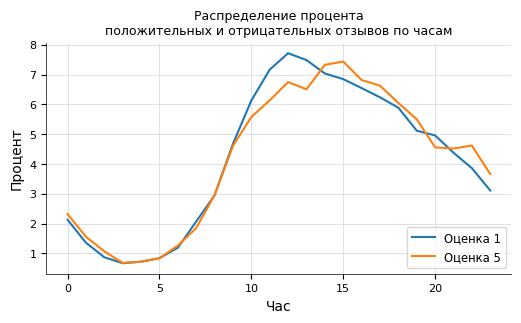

In [199]:
fig, ax = plt.subplots(figsize=(6, 3))
for rating in [1, 5]:
    rating_data = pos_and_neg_hour[pos_and_neg_hour['rating'] == rating]
    ax.plot(rating_data['hour'], rating_data['percentage'], label=f'Оценка {rating}')

ax.set_xlabel('Час')
ax.set_ylabel('Процент')
ax.set_title('Распределение процента\nположительных и отрицательных отзывов по часам', fontsize=9)
ax.legend(fontsize='small', loc='lower right')
plt.grid(True, linestyle='-', linewidth=0.5, color='lightgrey')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
plt.show()


А сейчас минутка nlp

In [ ]:
import nltk
from nltk.corpus import stopwords
ru_stopwords = stopwords.words("russian")
from nltk.tokenize import sent_tokenize, word_tokenize
import pymorphy3
from nltk.stem import SnowballStemmer
import time

In [ ]:
from bs4 import BeautifulSoup
import re
def preprocess(data):
    cleaned_body = []
    morph = pymorphy3.MorphAnalyzer()
    for b in data['body']:
        soup = BeautifulSoup(b, 'html.parser')
        text = soup.get_text()
        b = re.findall(r'<p>(.*?)<\/p>', text)
        if not b:
            b = text
        b = ''.join(b).lower()
        words = re.findall(r'\b\w+\b', b)
        processed_words = []
        for w in words:
            if w.isalpha() and len(w) > 1 and w not in ru_stopwords:
                w = w.strip()
                try:
                    w = morph.parse(w)[0].normal_form
                    processed_words.append(w)
                except:
                    processed_words.append(w)

        cleaned_body.append(' '.join(processed_words))
    data['cleaned_body'] = cleaned_body
    return data

In [ ]:
# nlp_cols = 'body cleaned_body title bank_name rating		date	month	day	hour	minute	second	'.split()
# nlp_data = preprocess(data)[nlp_cols]
# nlp_data['title'] = nlp_data['title'].lower( )
# # nlp_data = nlp_data[nlp_cols]
# nlp_data

In [ ]:
# text_data = 'body cleaned_body title bank_name'.split()
# nlp_data[text_data]